In [31]:
!pip install filetype

  Using cached filetype-1.2.0-py2.py3-none-any.whl.metadata (6.5 kB)


In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [2]:
# Avoid OOM (out of memory ) errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

 # meaningless here because i have a cpu

In [3]:
import cv2
import filetype

In [4]:
data_dir = 'data'

In [5]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = filetype.guess(image_path)
            if tip.extension not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image{}'.format(image_path))
            # os.remove(image_path)

 ## Load Data

In [7]:
import numpy as np

In [8]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [9]:
data_iterator = data.as_numpy_iterator()
data_iterator

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x000001254FDE9D30>)

In [10]:
# Get Another bacth from the iterator
bacth = data_iterator.next()

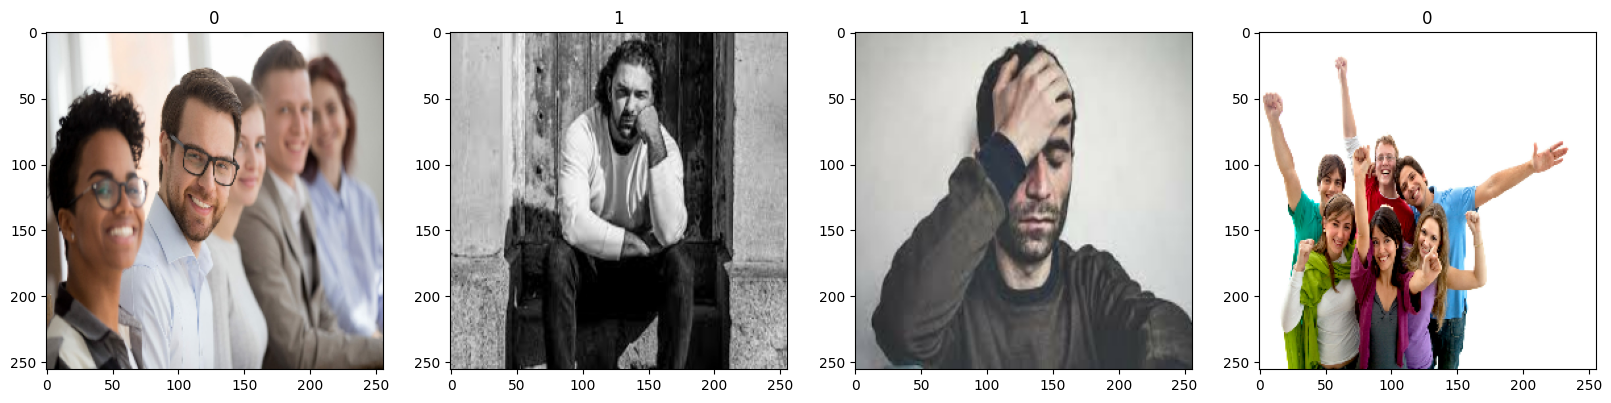

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(bacth[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(bacth[1][idx])

## Preprocess Data

### Scale Data

In [12]:
data = data.map(lambda x,y: (x/255, y))

In [13]:
scaled_iterator = data.as_numpy_iterator()

In [14]:
bacth = scaled_iterator.next()

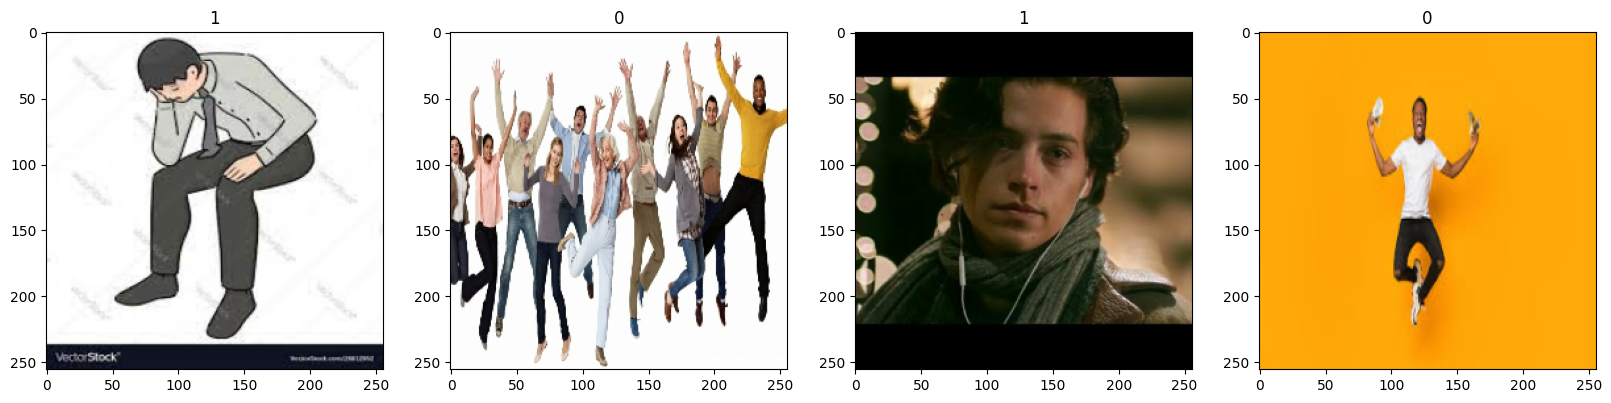

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(bacth[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(bacth[1][idx])

### Split data

In [16]:
len(data)

10

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Deep Model

### Build Deep Learning Model 

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input

In [20]:
model = Sequential([
    Input(shape=(256, 256, 3)),

    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(),

    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),

    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [21]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

## Train

In [23]:
logdir = 'logs'

In [24]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [25]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 536ms/step - accuracy: 0.5268 - loss: 0.9336 - val_accuracy: 0.5156 - val_loss: 0.6704
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 544ms/step - accuracy: 0.5223 - loss: 0.6674 - val_accuracy: 0.4375 - val_loss: 0.7139
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 504ms/step - accuracy: 0.5402 - loss: 0.6374 - val_accuracy: 0.4219 - val_loss: 0.6436
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 550ms/step - accuracy: 0.6161 - loss: 0.5970 - val_accuracy: 0.7812 - val_loss: 0.5825
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 567ms/step - accuracy: 0.7589 - loss: 0.6047 - val_accuracy: 0.8438 - val_loss: 0.4513
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 579ms/step - accuracy: 0.8795 - loss: 0.4099 - val_accuracy: 0.9219 - val_loss: 0.3798
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 489ms/step - accuracy: 0.8393 - loss: 0.4130 - val_accuracy: 0.9531 - val_loss: 0.2804
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 599ms/step - accuracy: 0.8884 - loss: 0.3231 - val_accuracy: 0.9062 - val_loss:

## Evaluation

In [26]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [27]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [28]:
for bacth in test.as_numpy_iterator():
    X, y = bacth
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


In [29]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


## Test

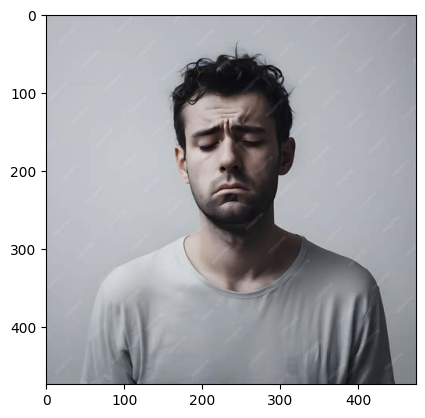

In [30]:
img = cv2.imread('sad_test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

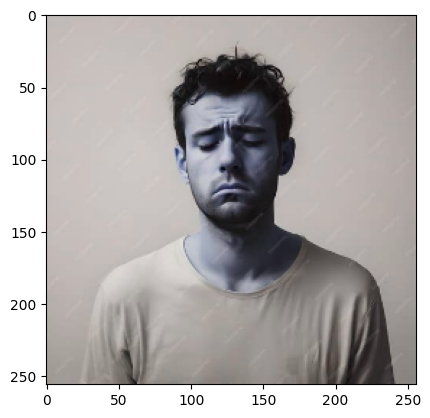

In [31]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [32]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


In [33]:
yhat

array([[0.99596727]], dtype=float32)

In [34]:
if yhat > 0.5:
    print('This person is Sad')
else:
    print('This person is Happy')

This person is Sad


### Save the model

In [36]:
from tensorflow.keras.models import load_model

In [115]:
model.save(os.path.join('models', 'happysadmodel.keras'))

In [37]:
new_model = load_model(os.path.join('models', 'happysadmodel.keras'))

C:\Users\dieng\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [38]:
yhat_new = new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


In [39]:
yhat_new

array([[0.991333]], dtype=float32)

In [40]:
if yhat_new > 0.5:
    print('This person is Sad')
else:
    print('This person is Happy')

This person is Sad
